Episode 10
Steps: 102
Average Reward: -96.00
Success Rate: 8.00%
Best Reward: -24.00
length: 102
loss: -13.673029899597168
--------------------------------------------------
Episode 20
Steps: 52
Average Reward: -77.60
Success Rate: 17.00%
Best Reward: -24.00
length: 52
loss: -5.387212753295898
--------------------------------------------------
Episode 30
Steps: 42
Average Reward: -78.10
Success Rate: 25.00%
Best Reward: -24.00
length: 42
loss: -40.857627868652344
--------------------------------------------------
Episode 40
Steps: 49
Average Reward: -73.38
Success Rate: 34.00%
Best Reward: -13.00
length: 49
loss: -62.922325134277344
--------------------------------------------------
Episode 50
Steps: 80
Average Reward: -74.20
Success Rate: 42.00%
Best Reward: -13.00
length: 80
loss: -112.71363830566406
--------------------------------------------------
Episode 60
Steps: 41
Average Reward: -75.05
Success Rate: 50.00%
Best Reward: -13.00
length: 41
loss: -55.15721130371094
--------------

Episode 500
Steps: 68
Average Reward: -73.09
Success Rate: 74.00%
Best Reward: -4.00
length: 68
loss: -2.489297866821289
--------------------------------------------------
Episode 510
Steps: 77
Average Reward: -70.10
Success Rate: 77.00%
Best Reward: -4.00
length: 77
loss: -60.235836029052734
--------------------------------------------------
Episode 520
Steps: 32
Average Reward: -68.75
Success Rate: 79.00%
Best Reward: -4.00
length: 32
loss: -35.79461669921875
--------------------------------------------------
Episode 530
Steps: 209
Average Reward: -73.93
Success Rate: 76.00%
Best Reward: -4.00
length: 209
loss: 1.5875740051269531
--------------------------------------------------
Episode 540
Steps: 70
Average Reward: -79.19
Success Rate: 72.00%
Best Reward: -4.00
length: 70
loss: -28.375736236572266
--------------------------------------------------
Episode 550
Steps: 76
Average Reward: -79.36
Success Rate: 72.00%
Best Reward: -4.00
length: 76
loss: -43.46131134033203
---------------

Episode 990
Steps: 53
Average Reward: -76.32
Success Rate: 73.00%
Best Reward: -4.00
length: 53
loss: -51.26332092285156
--------------------------------------------------
Episode 1000
Steps: 174
Average Reward: -84.32
Success Rate: 68.00%
Best Reward: -4.00
length: 174
loss: 59.04505920410156
--------------------------------------------------
Episode 1010
Steps: 77
Average Reward: -81.28
Success Rate: 70.00%
Best Reward: -4.00
length: 77
loss: 7.991682052612305
--------------------------------------------------
Episode 1020
Steps: 132
Average Reward: -88.08
Success Rate: 66.00%
Best Reward: -4.00
length: 132
loss: 0.7059941291809082
--------------------------------------------------
Episode 1030
Steps: 72
Average Reward: -89.18
Success Rate: 65.00%
Best Reward: -4.00
length: 72
loss: -56.774452209472656
--------------------------------------------------
Episode 1040
Steps: 89
Average Reward: -90.68
Success Rate: 67.00%
Best Reward: -4.00
length: 89
loss: 53.318546295166016
-----------

Episode 1480
Steps: 105
Average Reward: -87.37
Success Rate: 63.00%
Best Reward: -4.00
length: 105
loss: -10.206717491149902
--------------------------------------------------
Episode 1490
Steps: 150
Average Reward: -87.38
Success Rate: 64.00%
Best Reward: -4.00
length: 150
loss: -247.12835693359375
--------------------------------------------------
Episode 1500
Steps: 109
Average Reward: -90.60
Success Rate: 64.00%
Best Reward: -4.00
length: 109
loss: -23.224885940551758
--------------------------------------------------
Episode 1510
Steps: 35
Average Reward: -88.63
Success Rate: 66.00%
Best Reward: -4.00
length: 35
loss: -13.715934753417969
--------------------------------------------------
Episode 1520
Steps: 361
Average Reward: -94.48
Success Rate: 64.00%
Best Reward: -4.00
length: 361
loss: -110.84127044677734
--------------------------------------------------
Episode 1530
Steps: 72
Average Reward: -94.23
Success Rate: 64.00%
Best Reward: -4.00
length: 72
loss: -53.06963348388672


Episode 1950
Steps: 61
Average Reward: -86.36
Success Rate: 71.00%
Best Reward: -4.00
length: 61
loss: 24.753934860229492
--------------------------------------------------
Episode 1960
Steps: 88
Average Reward: -85.86
Success Rate: 70.00%
Best Reward: -4.00
length: 88
loss: -102.64473724365234
--------------------------------------------------
Episode 1970
Steps: 72
Average Reward: -84.74
Success Rate: 72.00%
Best Reward: -4.00
length: 72
loss: -42.15336608886719
--------------------------------------------------
Episode 1980
Steps: 107
Average Reward: -81.96
Success Rate: 74.00%
Best Reward: -4.00
length: 107
loss: -14.351997375488281
--------------------------------------------------
Episode 1990
Steps: 38
Average Reward: -81.68
Success Rate: 73.00%
Best Reward: -4.00
length: 38
loss: -17.274147033691406
--------------------------------------------------
Episode 2000
Steps: 51
Average Reward: -81.62
Success Rate: 74.00%
Best Reward: -4.00
length: 51
loss: -75.03336334228516
--------

Episode 2440
Steps: 39
Average Reward: -94.22
Success Rate: 67.00%
Best Reward: -4.00
length: 39
loss: -80.24787139892578
--------------------------------------------------
Episode 2450
Steps: 124
Average Reward: -93.44
Success Rate: 66.00%
Best Reward: -4.00
length: 124
loss: -23.838369369506836
--------------------------------------------------
Episode 2460
Steps: 122
Average Reward: -91.17
Success Rate: 65.00%
Best Reward: -4.00
length: 122
loss: -64.1883544921875
--------------------------------------------------
Episode 2470
Steps: 377
Average Reward: -97.16
Success Rate: 61.00%
Best Reward: -4.00
length: 377
loss: -240.85797119140625
--------------------------------------------------
Episode 2480
Steps: 277
Average Reward: -98.08
Success Rate: 61.00%
Best Reward: -4.00
length: 277
loss: -153.4231719970703
--------------------------------------------------
Episode 2490
Steps: 22
Average Reward: -95.10
Success Rate: 62.00%
Best Reward: -4.00
length: 22
loss: -19.877988815307617
---

Episode 2930
Steps: 49
Average Reward: -92.10
Success Rate: 69.00%
Best Reward: -4.00
length: 49
loss: -9.017827033996582
--------------------------------------------------
Episode 2940
Steps: 93
Average Reward: -90.53
Success Rate: 72.00%
Best Reward: -4.00
length: 93
loss: -13.11981201171875
--------------------------------------------------
Episode 2950
Steps: 58
Average Reward: -89.49
Success Rate: 73.00%
Best Reward: -4.00
length: 58
loss: -20.603206634521484
--------------------------------------------------
Episode 2960
Steps: 211
Average Reward: -85.70
Success Rate: 74.00%
Best Reward: -4.00
length: 211
loss: -173.93307495117188
--------------------------------------------------
Episode 2970
Steps: 148
Average Reward: -87.47
Success Rate: 72.00%
Best Reward: -4.00
length: 148
loss: -6.101963043212891
--------------------------------------------------
Episode 2980
Steps: 96
Average Reward: -88.88
Success Rate: 72.00%
Best Reward: -4.00
length: 96
loss: -60.15772247314453
-------

Episode 3420
Steps: 51
Average Reward: -93.35
Success Rate: 67.00%
Best Reward: -4.00
length: 51
loss: -40.30653381347656
--------------------------------------------------
Episode 3430
Steps: 81
Average Reward: -94.07
Success Rate: 66.00%
Best Reward: -4.00
length: 81
loss: 42.710670471191406
--------------------------------------------------
Episode 3440
Steps: 116
Average Reward: -98.30
Success Rate: 63.00%
Best Reward: -4.00
length: 116
loss: 59.432411193847656
--------------------------------------------------
Episode 3450
Steps: 43
Average Reward: -99.63
Success Rate: 64.00%
Best Reward: -4.00
length: 43
loss: -49.28471755981445
--------------------------------------------------
Episode 3460
Steps: 126
Average Reward: -104.23
Success Rate: 62.00%
Best Reward: -4.00
length: 126
loss: -20.649324417114258
--------------------------------------------------
Episode 3470
Steps: 19
Average Reward: -102.97
Success Rate: 61.00%
Best Reward: -4.00
length: 19
loss: -31.887834548950195
-----

Episode 3900
Steps: 113
Average Reward: -77.11
Success Rate: 75.00%
Best Reward: -4.00
length: 113
loss: -84.91401672363281
--------------------------------------------------
Episode 3910
Steps: 30
Average Reward: -77.39
Success Rate: 73.00%
Best Reward: -4.00
length: 30
loss: -54.010868072509766
--------------------------------------------------
Episode 3920
Steps: 98
Average Reward: -74.50
Success Rate: 75.00%
Best Reward: -4.00
length: 98
loss: -123.52963256835938
--------------------------------------------------
Episode 3930
Steps: 115
Average Reward: -76.16
Success Rate: 74.00%
Best Reward: -4.00
length: 115
loss: -76.58325958251953
--------------------------------------------------
Episode 3940
Steps: 125
Average Reward: -78.57
Success Rate: 73.00%
Best Reward: -4.00
length: 125
loss: 17.013824462890625
--------------------------------------------------
Episode 3950
Steps: 32
Average Reward: -77.91
Success Rate: 74.00%
Best Reward: -4.00
length: 32
loss: -49.28556823730469
-----

Episode 4380
Steps: 54
Average Reward: -82.54
Success Rate: 67.00%
Best Reward: -4.00
length: 54
loss: -18.712665557861328
--------------------------------------------------
Episode 4390
Steps: 118
Average Reward: -83.03
Success Rate: 66.00%
Best Reward: -4.00
length: 118
loss: 41.40105438232422
--------------------------------------------------
Episode 4400
Steps: 80
Average Reward: -87.23
Success Rate: 63.00%
Best Reward: -4.00
length: 80
loss: -77.43243408203125
--------------------------------------------------
Episode 4410
Steps: 94
Average Reward: -86.75
Success Rate: 64.00%
Best Reward: -4.00
length: 94
loss: -79.94306945800781
--------------------------------------------------
Episode 4420
Steps: 56
Average Reward: -87.42
Success Rate: 63.00%
Best Reward: -4.00
length: 56
loss: -71.09999084472656
--------------------------------------------------
Episode 4430
Steps: 88
Average Reward: -91.46
Success Rate: 60.00%
Best Reward: -4.00
length: 88
loss: -82.58585357666016
-----------

Episode 4870
Steps: 34
Average Reward: -76.70
Success Rate: 75.00%
Best Reward: -4.00
length: 34
loss: -22.412181854248047
--------------------------------------------------
Episode 4880
Steps: 291
Average Reward: -78.35
Success Rate: 76.00%
Best Reward: -4.00
length: 291
loss: -56.07944107055664
--------------------------------------------------
Episode 4890
Steps: 156
Average Reward: -84.58
Success Rate: 74.00%
Best Reward: -4.00
length: 156
loss: -179.8687286376953
--------------------------------------------------
Episode 4900
Steps: 220
Average Reward: -87.09
Success Rate: 72.00%
Best Reward: -4.00
length: 220
loss: 181.27488708496094
--------------------------------------------------
Episode 4910
Steps: 57
Average Reward: -87.87
Success Rate: 72.00%
Best Reward: -4.00
length: 57
loss: -51.20387268066406
--------------------------------------------------
Episode 4920
Steps: 105
Average Reward: -89.31
Success Rate: 71.00%
Best Reward: -4.00
length: 105
loss: -67.59003448486328
----

Episode 5360
Steps: 195
Average Reward: -88.98
Success Rate: 69.00%
Best Reward: -4.00
length: 195
loss: -144.86668395996094
--------------------------------------------------
Episode 5370
Steps: 61
Average Reward: -85.44
Success Rate: 71.00%
Best Reward: -4.00
length: 61
loss: -33.274044036865234
--------------------------------------------------
Episode 5380
Steps: 66
Average Reward: -84.96
Success Rate: 71.00%
Best Reward: -4.00
length: 66
loss: -49.434234619140625
--------------------------------------------------
Episode 5390
Steps: 91
Average Reward: -84.17
Success Rate: 71.00%
Best Reward: -4.00
length: 91
loss: -89.98220825195312
--------------------------------------------------
Episode 5400
Steps: 79
Average Reward: -85.15
Success Rate: 70.00%
Best Reward: -4.00
length: 79
loss: -40.116615295410156
--------------------------------------------------
Episode 5410
Steps: 49
Average Reward: -86.16
Success Rate: 68.00%
Best Reward: -4.00
length: 49
loss: -50.23920440673828
-------

Episode 5850
Steps: 134
Average Reward: -85.76
Success Rate: 71.00%
Best Reward: -4.00
length: 134
loss: 57.02861785888672
--------------------------------------------------
Episode 5860
Steps: 56
Average Reward: -82.60
Success Rate: 73.00%
Best Reward: -4.00
length: 56
loss: 3.4576797485351562
--------------------------------------------------
Episode 5870
Steps: 116
Average Reward: -84.09
Success Rate: 71.00%
Best Reward: -4.00
length: 116
loss: -113.64517974853516
--------------------------------------------------
Episode 5880
Steps: 72
Average Reward: -82.76
Success Rate: 71.00%
Best Reward: -4.00
length: 72
loss: -60.51900100708008
--------------------------------------------------
Episode 5890
Steps: 195
Average Reward: -85.28
Success Rate: 67.00%
Best Reward: -4.00
length: 195
loss: -68.28987121582031
--------------------------------------------------
Episode 5900
Steps: 34
Average Reward: -83.39
Success Rate: 69.00%
Best Reward: -4.00
length: 34
loss: 1.4650312662124634
-------

Episode 6340
Steps: 161
Average Reward: -86.61
Success Rate: 66.00%
Best Reward: -4.00
length: 161
loss: 39.84113693237305
--------------------------------------------------
Episode 6350
Steps: 82
Average Reward: -87.93
Success Rate: 64.00%
Best Reward: -4.00
length: 82
loss: -78.5333251953125
--------------------------------------------------
Episode 6360
Steps: 41
Average Reward: -90.32
Success Rate: 63.00%
Best Reward: -4.00
length: 41
loss: -8.84496021270752
--------------------------------------------------
Episode 6370
Steps: 160
Average Reward: -90.85
Success Rate: 64.00%
Best Reward: -4.00
length: 160
loss: -83.16851043701172
--------------------------------------------------
Episode 6380
Steps: 182
Average Reward: -92.21
Success Rate: 62.00%
Best Reward: -4.00
length: 182
loss: -34.33413314819336
--------------------------------------------------
Episode 6390
Steps: 49
Average Reward: -93.00
Success Rate: 62.00%
Best Reward: -4.00
length: 49
loss: -72.87405395507812
----------

Episode 6830
Steps: 83
Average Reward: -80.94
Success Rate: 67.00%
Best Reward: -4.00
length: 83
loss: -21.4389591217041
--------------------------------------------------
Episode 6840
Steps: 101
Average Reward: -82.06
Success Rate: 69.00%
Best Reward: -4.00
length: 101
loss: -28.363162994384766
--------------------------------------------------
Episode 6850
Steps: 154
Average Reward: -82.60
Success Rate: 68.00%
Best Reward: -4.00
length: 154
loss: -18.364065170288086
--------------------------------------------------
Episode 6860
Steps: 96
Average Reward: -83.58
Success Rate: 67.00%
Best Reward: -4.00
length: 96
loss: -32.57090377807617
--------------------------------------------------
Episode 6870
Steps: 34
Average Reward: -81.13
Success Rate: 69.00%
Best Reward: -4.00
length: 34
loss: 4.857635498046875
--------------------------------------------------
Episode 6880
Steps: 94
Average Reward: -81.05
Success Rate: 68.00%
Best Reward: -4.00
length: 94
loss: -119.16905212402344
--------

Episode 7310
Steps: 176
Average Reward: -98.86
Success Rate: 60.00%
Best Reward: -4.00
length: 176
loss: -95.26900482177734
--------------------------------------------------
Episode 7320
Steps: 72
Average Reward: -105.25
Success Rate: 57.00%
Best Reward: -4.00
length: 72
loss: 46.1429443359375
--------------------------------------------------
Episode 7330
Steps: 116
Average Reward: -102.67
Success Rate: 59.00%
Best Reward: -4.00
length: 116
loss: -51.85032653808594
--------------------------------------------------
Episode 7340
Steps: 76
Average Reward: -102.11
Success Rate: 59.00%
Best Reward: -4.00
length: 76
loss: 18.08157730102539
--------------------------------------------------
Episode 7350
Steps: 99
Average Reward: -101.72
Success Rate: 58.00%
Best Reward: -4.00
length: 99
loss: -64.16099548339844
--------------------------------------------------
Episode 7360
Steps: 153
Average Reward: -105.88
Success Rate: 56.00%
Best Reward: -4.00
length: 153
loss: 97.10281372070312
------

Episode 7790
Steps: 154
Average Reward: -88.93
Success Rate: 66.00%
Best Reward: -4.00
length: 154
loss: 64.36144256591797
--------------------------------------------------
Episode 7800
Steps: 111
Average Reward: -86.59
Success Rate: 68.00%
Best Reward: -4.00
length: 111
loss: -10.619921684265137
--------------------------------------------------
Episode 7810
Steps: 175
Average Reward: -85.27
Success Rate: 68.00%
Best Reward: -4.00
length: 175
loss: 15.975424766540527
--------------------------------------------------
Episode 7820
Steps: 66
Average Reward: -82.55
Success Rate: 70.00%
Best Reward: -4.00
length: 66
loss: -27.52930450439453
--------------------------------------------------
Episode 7830
Steps: 36
Average Reward: -82.35
Success Rate: 68.00%
Best Reward: -4.00
length: 36
loss: -33.84270477294922
--------------------------------------------------
Episode 7840
Steps: 42
Average Reward: -80.17
Success Rate: 69.00%
Best Reward: -4.00
length: 42
loss: -32.82746505737305
-------

Episode 8280
Steps: 32
Average Reward: -89.39
Success Rate: 68.00%
Best Reward: -4.00
length: 32
loss: -98.69821166992188
--------------------------------------------------
Episode 8290
Steps: 119
Average Reward: -88.30
Success Rate: 69.00%
Best Reward: -4.00
length: 119
loss: 21.510910034179688
--------------------------------------------------
Episode 8300
Steps: 30
Average Reward: -84.86
Success Rate: 71.00%
Best Reward: -4.00
length: 30
loss: -73.98994445800781
--------------------------------------------------
Episode 8310
Steps: 86
Average Reward: -85.44
Success Rate: 71.00%
Best Reward: -4.00
length: 86
loss: -51.87763977050781
--------------------------------------------------
Episode 8320
Steps: 53
Average Reward: -86.14
Success Rate: 72.00%
Best Reward: -4.00
length: 53
loss: -42.691123962402344
--------------------------------------------------
Episode 8330
Steps: 59
Average Reward: -82.19
Success Rate: 75.00%
Best Reward: -4.00
length: 59
loss: -10.279478073120117
---------

Episode 8760
Steps: 32
Average Reward: -107.04
Success Rate: 55.00%
Best Reward: -4.00
length: 32
loss: -22.121883392333984
--------------------------------------------------
Episode 8770
Steps: 43
Average Reward: -101.47
Success Rate: 58.00%
Best Reward: -4.00
length: 43
loss: -52.26444625854492
--------------------------------------------------
Episode 8780
Steps: 33
Average Reward: -98.84
Success Rate: 61.00%
Best Reward: -4.00
length: 33
loss: -72.06488800048828
--------------------------------------------------
Episode 8790
Steps: 82
Average Reward: -96.55
Success Rate: 63.00%
Best Reward: -4.00
length: 82
loss: -97.7089614868164
--------------------------------------------------
Episode 8800
Steps: 157
Average Reward: -95.90
Success Rate: 65.00%
Best Reward: -4.00
length: 157
loss: -45.46409606933594
--------------------------------------------------
Episode 8810
Steps: 60
Average Reward: -93.70
Success Rate: 67.00%
Best Reward: -4.00
length: 60
loss: -44.20178985595703
---------

Episode 9250
Steps: 67
Average Reward: -101.09
Success Rate: 59.00%
Best Reward: -4.00
length: 67
loss: -47.7132568359375
--------------------------------------------------
Episode 9260
Steps: 98
Average Reward: -95.30
Success Rate: 64.00%
Best Reward: -4.00
length: 98
loss: 14.023088455200195
--------------------------------------------------
Episode 9270
Steps: 186
Average Reward: -90.92
Success Rate: 65.00%
Best Reward: -4.00
length: 186
loss: -81.13397216796875
--------------------------------------------------
Episode 9280
Steps: 218
Average Reward: -88.80
Success Rate: 66.00%
Best Reward: -4.00
length: 218
loss: -81.73400115966797
--------------------------------------------------
Episode 9290
Steps: 78
Average Reward: -85.93
Success Rate: 69.00%
Best Reward: -4.00
length: 78
loss: 39.912635803222656
--------------------------------------------------
Episode 9300
Steps: 57
Average Reward: -90.34
Success Rate: 69.00%
Best Reward: -4.00
length: 57
loss: -2.8772706985473633
--------

Episode 9740
Steps: 93
Average Reward: -80.67
Success Rate: 70.00%
Best Reward: -4.00
length: 93
loss: -49.66965866088867
--------------------------------------------------
Episode 9750
Steps: 129
Average Reward: -81.59
Success Rate: 69.00%
Best Reward: -4.00
length: 129
loss: -15.082569122314453
--------------------------------------------------
Episode 9760
Steps: 106
Average Reward: -85.88
Success Rate: 67.00%
Best Reward: -4.00
length: 106
loss: 41.64122009277344
--------------------------------------------------
Episode 9770
Steps: 207
Average Reward: -88.65
Success Rate: 66.00%
Best Reward: -4.00
length: 207
loss: -106.91625213623047
--------------------------------------------------
Episode 9780
Steps: 199
Average Reward: -88.54
Success Rate: 66.00%
Best Reward: -4.00
length: 199
loss: -3.6151208877563477
--------------------------------------------------
Episode 9790
Steps: 55
Average Reward: -91.91
Success Rate: 64.00%
Best Reward: -4.00
length: 55
loss: -23.541479110717773
--

Episode 10220
Steps: 90
Average Reward: -102.65
Success Rate: 59.00%
Best Reward: -4.00
length: 90
loss: 29.771846771240234
--------------------------------------------------
Episode 10230
Steps: 226
Average Reward: -103.59
Success Rate: 59.00%
Best Reward: -4.00
length: 226
loss: -97.6776123046875
--------------------------------------------------
Episode 10240
Steps: 42
Average Reward: -101.56
Success Rate: 59.00%
Best Reward: -4.00
length: 42
loss: -100.73920440673828
--------------------------------------------------
Episode 10250
Steps: 51
Average Reward: -105.62
Success Rate: 57.00%
Best Reward: -4.00
length: 51
loss: -86.02754211425781
--------------------------------------------------
Episode 10260
Steps: 66
Average Reward: -105.86
Success Rate: 58.00%
Best Reward: -4.00
length: 66
loss: -34.719398498535156
--------------------------------------------------
Episode 10270
Steps: 40
Average Reward: -106.84
Success Rate: 60.00%
Best Reward: -4.00
length: 40
loss: -94.8664245605468

Episode 10690
Steps: 63
Average Reward: -66.68
Success Rate: 80.00%
Best Reward: -4.00
length: 63
loss: -120.18839263916016
--------------------------------------------------
Episode 10700
Steps: 85
Average Reward: -65.69
Success Rate: 82.00%
Best Reward: -4.00
length: 85
loss: -32.465782165527344
--------------------------------------------------
Episode 10710
Steps: 69
Average Reward: -63.98
Success Rate: 82.00%
Best Reward: -4.00
length: 69
loss: -10.777481079101562
--------------------------------------------------
Episode 10720
Steps: 172
Average Reward: -64.56
Success Rate: 81.00%
Best Reward: -4.00
length: 172
loss: -136.93408203125
--------------------------------------------------
Episode 10730
Steps: 73
Average Reward: -66.43
Success Rate: 80.00%
Best Reward: -4.00
length: 73
loss: -12.148696899414062
--------------------------------------------------
Episode 10740
Steps: 66
Average Reward: -72.58
Success Rate: 77.00%
Best Reward: -4.00
length: 66
loss: -32.616249084472656
--

Episode 11170
Steps: 53
Average Reward: -85.08
Success Rate: 72.00%
Best Reward: -4.00
length: 53
loss: -24.78785514831543
--------------------------------------------------
Episode 11180
Steps: 73
Average Reward: -90.20
Success Rate: 67.00%
Best Reward: -4.00
length: 73
loss: -38.12839889526367
--------------------------------------------------
Episode 11190
Steps: 58
Average Reward: -88.49
Success Rate: 68.00%
Best Reward: -4.00
length: 58
loss: -47.78431701660156
--------------------------------------------------
Episode 11200
Steps: 106
Average Reward: -92.67
Success Rate: 67.00%
Best Reward: -4.00
length: 106
loss: -34.20527648925781
--------------------------------------------------
Episode 11210
Steps: 53
Average Reward: -96.06
Success Rate: 65.00%
Best Reward: -4.00
length: 53
loss: -32.02594757080078
--------------------------------------------------
Episode 11220
Steps: 55
Average Reward: -95.99
Success Rate: 65.00%
Best Reward: -4.00
length: 55
loss: -39.50947189331055
-----

Episode 11650
Steps: 94
Average Reward: -97.61
Success Rate: 66.00%
Best Reward: -4.00
length: 94
loss: 12.286487579345703
--------------------------------------------------
Episode 11660
Steps: 87
Average Reward: -96.30
Success Rate: 67.00%
Best Reward: -4.00
length: 87
loss: -33.279354095458984
--------------------------------------------------
Episode 11670
Steps: 36
Average Reward: -93.08
Success Rate: 70.00%
Best Reward: -4.00
length: 36
loss: -35.38999938964844
--------------------------------------------------
Episode 11680
Steps: 95
Average Reward: -92.49
Success Rate: 70.00%
Best Reward: -4.00
length: 95
loss: -30.878456115722656
--------------------------------------------------
Episode 11690
Steps: 163
Average Reward: -93.18
Success Rate: 70.00%
Best Reward: -4.00
length: 163
loss: -100.25907897949219
--------------------------------------------------
Episode 11700
Steps: 72
Average Reward: -90.69
Success Rate: 72.00%
Best Reward: -4.00
length: 72
loss: -44.70147705078125
--

Episode 12120
Steps: 325
Average Reward: -96.56
Success Rate: 64.00%
Best Reward: -4.00
length: 325
loss: -116.65763854980469
--------------------------------------------------
Episode 12130
Steps: 60
Average Reward: -91.08
Success Rate: 67.00%
Best Reward: -4.00
length: 60
loss: -22.580965042114258
--------------------------------------------------
Episode 12140
Steps: 90
Average Reward: -97.29
Success Rate: 61.00%
Best Reward: -4.00
length: 90
loss: -55.73492431640625
--------------------------------------------------
Episode 12150
Steps: 37
Average Reward: -97.95
Success Rate: 62.00%
Best Reward: -4.00
length: 37
loss: -69.36930084228516
--------------------------------------------------
Episode 12160
Steps: 68
Average Reward: -94.95
Success Rate: 65.00%
Best Reward: -4.00
length: 68
loss: -44.69559097290039
--------------------------------------------------
Episode 12170
Steps: 129
Average Reward: -98.67
Success Rate: 63.00%
Best Reward: -4.00
length: 129
loss: -77.55786895751953
-

Episode 12600
Steps: 65
Average Reward: -98.87
Success Rate: 74.00%
Best Reward: -4.00
length: 65
loss: -74.71870422363281
--------------------------------------------------
Episode 12610
Steps: 162
Average Reward: -100.88
Success Rate: 73.00%
Best Reward: -4.00
length: 162
loss: -6.417560577392578
--------------------------------------------------
Episode 12620
Steps: 102
Average Reward: -103.06
Success Rate: 69.00%
Best Reward: -4.00
length: 102
loss: 7.666374206542969
--------------------------------------------------
Episode 12630
Steps: 162
Average Reward: -89.29
Success Rate: 73.00%
Best Reward: -4.00
length: 162
loss: 32.28374481201172
--------------------------------------------------
Episode 12640
Steps: 160
Average Reward: -90.24
Success Rate: 72.00%
Best Reward: -4.00
length: 160
loss: -73.90217590332031
--------------------------------------------------
Episode 12650
Steps: 27
Average Reward: -88.13
Success Rate: 73.00%
Best Reward: -4.00
length: 27
loss: -17.44075012207031

Episode 13080
Steps: 123
Average Reward: -97.90
Success Rate: 61.00%
Best Reward: -4.00
length: 123
loss: -48.83662033081055
--------------------------------------------------
Episode 13090
Steps: 38
Average Reward: -99.72
Success Rate: 61.00%
Best Reward: -4.00
length: 38
loss: -99.5534439086914
--------------------------------------------------
Episode 13100
Steps: 69
Average Reward: -99.37
Success Rate: 63.00%
Best Reward: -4.00
length: 69
loss: -61.7028694152832
--------------------------------------------------
Episode 13110
Steps: 114
Average Reward: -101.16
Success Rate: 60.00%
Best Reward: -4.00
length: 114
loss: 96.32368469238281
--------------------------------------------------
Episode 13120
Steps: 86
Average Reward: -102.11
Success Rate: 57.00%
Best Reward: -4.00
length: 86
loss: -25.279273986816406
--------------------------------------------------
Episode 13130
Steps: 69
Average Reward: -105.07
Success Rate: 57.00%
Best Reward: -4.00
length: 69
loss: -18.37652587890625
--

Episode 13550
Steps: 39
Average Reward: -87.66
Success Rate: 57.00%
Best Reward: -4.00
length: 39
loss: -1.4571887254714966
--------------------------------------------------
Episode 13560
Steps: 112
Average Reward: -89.61
Success Rate: 57.00%
Best Reward: -4.00
length: 112
loss: -8.922597885131836
--------------------------------------------------
Episode 13570
Steps: 271
Average Reward: -87.57
Success Rate: 62.00%
Best Reward: -4.00
length: 271
loss: -28.25752067565918
--------------------------------------------------
Episode 13580
Steps: 91
Average Reward: -86.95
Success Rate: 64.00%
Best Reward: -4.00
length: 91
loss: -122.4954605102539
--------------------------------------------------
Episode 13590
Steps: 35
Average Reward: -83.48
Success Rate: 67.00%
Best Reward: -4.00
length: 35
loss: -13.449235916137695
--------------------------------------------------
Episode 13600
Steps: 84
Average Reward: -81.04
Success Rate: 70.00%
Best Reward: -4.00
length: 84
loss: 19.160444259643555
-

Episode 14020
Steps: 163
Average Reward: -89.67
Success Rate: 67.00%
Best Reward: -4.00
length: 163
loss: 3.906414031982422
--------------------------------------------------
Episode 14030
Steps: 66
Average Reward: -91.59
Success Rate: 66.00%
Best Reward: -4.00
length: 66
loss: -71.76846313476562
--------------------------------------------------
Episode 14040
Steps: 174
Average Reward: -87.01
Success Rate: 68.00%
Best Reward: -4.00
length: 174
loss: 77.8795166015625
--------------------------------------------------
Episode 14050
Steps: 62
Average Reward: -85.41
Success Rate: 67.00%
Best Reward: -4.00
length: 62
loss: -15.475400924682617
--------------------------------------------------
Episode 14060
Steps: 58
Average Reward: -83.73
Success Rate: 69.00%
Best Reward: -4.00
length: 58
loss: -9.554975509643555
--------------------------------------------------
Episode 14070
Steps: 74
Average Reward: -81.13
Success Rate: 70.00%
Best Reward: -4.00
length: 74
loss: -63.59834671020508
-----

Episode 14490
Steps: 60
Average Reward: -90.45
Success Rate: 68.00%
Best Reward: -4.00
length: 60
loss: -32.10600280761719
--------------------------------------------------
Episode 14500
Steps: 114
Average Reward: -88.68
Success Rate: 67.00%
Best Reward: -4.00
length: 114
loss: -11.369811058044434
--------------------------------------------------
Episode 14510
Steps: 25
Average Reward: -84.12
Success Rate: 70.00%
Best Reward: -4.00
length: 25
loss: -15.798325538635254
--------------------------------------------------
Episode 14520
Steps: 153
Average Reward: -87.61
Success Rate: 70.00%
Best Reward: -4.00
length: 153
loss: -13.35708999633789
--------------------------------------------------
Episode 14530
Steps: 51
Average Reward: -82.27
Success Rate: 71.00%
Best Reward: -4.00
length: 51
loss: -57.2978515625
--------------------------------------------------
Episode 14540
Steps: 92
Average Reward: -85.84
Success Rate: 68.00%
Best Reward: -4.00
length: 92
loss: -76.85014343261719
-----

Episode 14960
Steps: 104
Average Reward: -102.57
Success Rate: 60.00%
Best Reward: -4.00
length: 104
loss: 19.812196731567383
--------------------------------------------------
Episode 14970
Steps: 45
Average Reward: -101.11
Success Rate: 60.00%
Best Reward: -4.00
length: 45
loss: -27.111740112304688
--------------------------------------------------
Episode 14980
Steps: 53
Average Reward: -103.70
Success Rate: 59.00%
Best Reward: -4.00
length: 53
loss: -105.58526611328125
--------------------------------------------------
Episode 14990
Steps: 196
Average Reward: -105.51
Success Rate: 59.00%
Best Reward: -4.00
length: 196
loss: -62.96922302246094
--------------------------------------------------
Episode 15000
Steps: 29
Average Reward: -105.69
Success Rate: 59.00%
Best Reward: -4.00
length: 29
loss: -55.42259979248047
--------------------------------------------------
Episode 15010
Steps: 94
Average Reward: -103.82
Success Rate: 57.00%
Best Reward: -4.00
length: 94
loss: -126.732955932

Episode 15440
Steps: 103
Average Reward: -94.55
Success Rate: 64.00%
Best Reward: -4.00
length: 103
loss: -150.60873413085938
--------------------------------------------------
Episode 15450
Steps: 148
Average Reward: -93.91
Success Rate: 64.00%
Best Reward: -4.00
length: 148
loss: 1.7224102020263672
--------------------------------------------------
Episode 15460
Steps: 228
Average Reward: -94.21
Success Rate: 65.00%
Best Reward: -4.00
length: 228
loss: -233.25161743164062
--------------------------------------------------
Episode 15470
Steps: 207
Average Reward: -94.67
Success Rate: 65.00%
Best Reward: -4.00
length: 207
loss: -77.144775390625
--------------------------------------------------
Episode 15480
Steps: 111
Average Reward: -91.96
Success Rate: 67.00%
Best Reward: -4.00
length: 111
loss: -35.71467208862305
--------------------------------------------------
Episode 15490
Steps: 139
Average Reward: -92.72
Success Rate: 66.00%
Best Reward: -4.00
length: 139
loss: -15.7699871063

Episode 15920
Steps: 91
Average Reward: -93.34
Success Rate: 65.00%
Best Reward: -4.00
length: 91
loss: -16.459333419799805
--------------------------------------------------
Episode 15930
Steps: 70
Average Reward: -90.03
Success Rate: 69.00%
Best Reward: -4.00
length: 70
loss: -32.04259490966797
--------------------------------------------------
Episode 15940
Steps: 53
Average Reward: -88.96
Success Rate: 68.00%
Best Reward: -4.00
length: 53
loss: -57.84850311279297
--------------------------------------------------
Episode 15950
Steps: 96
Average Reward: -93.24
Success Rate: 66.00%
Best Reward: -4.00
length: 96
loss: -10.740100860595703
--------------------------------------------------
Episode 15960
Steps: 51
Average Reward: -91.12
Success Rate: 67.00%
Best Reward: -4.00
length: 51
loss: -20.66966438293457
--------------------------------------------------
Episode 15970
Steps: 73
Average Reward: -88.71
Success Rate: 69.00%
Best Reward: -4.00
length: 73
loss: -61.25257873535156
-----

Episode 16400
Steps: 84
Average Reward: -91.09
Success Rate: 64.00%
Best Reward: -4.00
length: 84
loss: -114.37166595458984
--------------------------------------------------
Episode 16410
Steps: 58
Average Reward: -92.21
Success Rate: 66.00%
Best Reward: -4.00
length: 58
loss: -66.45977783203125
--------------------------------------------------
Episode 16420
Steps: 109
Average Reward: -92.57
Success Rate: 66.00%
Best Reward: -4.00
length: 109
loss: -43.39011001586914
--------------------------------------------------
Episode 16430
Steps: 181
Average Reward: -94.66
Success Rate: 66.00%
Best Reward: -4.00
length: 181
loss: 46.54304504394531
--------------------------------------------------
Episode 16440
Steps: 215
Average Reward: -94.17
Success Rate: 66.00%
Best Reward: -4.00
length: 215
loss: -128.73768615722656
--------------------------------------------------
Episode 16450
Steps: 34
Average Reward: -90.35
Success Rate: 67.00%
Best Reward: -4.00
length: 34
loss: -67.39891052246094


Episode 16880
Steps: 48
Average Reward: -85.66
Success Rate: 69.00%
Best Reward: -4.00
length: 48
loss: -28.441911697387695
--------------------------------------------------
Episode 16890
Steps: 19
Average Reward: -79.77
Success Rate: 71.00%
Best Reward: -4.00
length: 19
loss: -33.95286560058594
--------------------------------------------------
Episode 16900
Steps: 285
Average Reward: -83.73
Success Rate: 68.00%
Best Reward: -4.00
length: 285
loss: -56.3267822265625
--------------------------------------------------
Episode 16910
Steps: 54
Average Reward: -84.98
Success Rate: 67.00%
Best Reward: -4.00
length: 54
loss: -0.45245814323425293
--------------------------------------------------
Episode 16920
Steps: 60
Average Reward: -83.91
Success Rate: 69.00%
Best Reward: -4.00
length: 60
loss: -5.680393695831299
--------------------------------------------------
Episode 16930
Steps: 100
Average Reward: -84.91
Success Rate: 69.00%
Best Reward: -4.00
length: 100
loss: -49.35049057006836
-

Episode 17350
Steps: 76
Average Reward: -93.75
Success Rate: 59.00%
Best Reward: -4.00
length: 76
loss: -50.826385498046875
--------------------------------------------------
Episode 17360
Steps: 75
Average Reward: -95.88
Success Rate: 58.00%
Best Reward: -4.00
length: 75
loss: 25.33031463623047
--------------------------------------------------
Episode 17370
Steps: 90
Average Reward: -93.39
Success Rate: 63.00%
Best Reward: -4.00
length: 90
loss: -44.80402755737305
--------------------------------------------------
Episode 17380
Steps: 108
Average Reward: -92.67
Success Rate: 66.00%
Best Reward: -4.00
length: 108
loss: 19.52194595336914
--------------------------------------------------
Episode 17390
Steps: 62
Average Reward: -89.91
Success Rate: 68.00%
Best Reward: -4.00
length: 62
loss: -12.419328689575195
--------------------------------------------------
Episode 17400
Steps: 72
Average Reward: -84.98
Success Rate: 72.00%
Best Reward: -4.00
length: 72
loss: -172.12503051757812
----

Episode 17820
Steps: 202
Average Reward: -89.88
Success Rate: 68.00%
Best Reward: -4.00
length: 202
loss: 65.953125
--------------------------------------------------
Episode 17830
Steps: 151
Average Reward: -91.18
Success Rate: 67.00%
Best Reward: -4.00
length: 151
loss: 21.78843116760254
--------------------------------------------------
Episode 17840
Steps: 52
Average Reward: -89.99
Success Rate: 67.00%
Best Reward: -4.00
length: 52
loss: -55.84844207763672
--------------------------------------------------
Episode 17850
Steps: 92
Average Reward: -90.92
Success Rate: 67.00%
Best Reward: -4.00
length: 92
loss: -25.44884490966797
--------------------------------------------------
Episode 17860
Steps: 165
Average Reward: -91.43
Success Rate: 66.00%
Best Reward: -4.00
length: 165
loss: -1.1215200424194336
--------------------------------------------------
Episode 17870
Steps: 459
Average Reward: -96.15
Success Rate: 63.00%
Best Reward: -4.00
length: 459
loss: 148.31072998046875
--------

Episode 18290
Steps: 156
Average Reward: -85.87
Success Rate: 70.00%
Best Reward: -4.00
length: 156
loss: -65.0245361328125
--------------------------------------------------
Episode 18300
Steps: 67
Average Reward: -86.80
Success Rate: 71.00%
Best Reward: -4.00
length: 67
loss: -59.95287322998047
--------------------------------------------------
Episode 18310
Steps: 80
Average Reward: -86.50
Success Rate: 71.00%
Best Reward: -4.00
length: 80
loss: -101.3678207397461
--------------------------------------------------
Episode 18320
Steps: 75
Average Reward: -79.66
Success Rate: 75.00%
Best Reward: -4.00
length: 75
loss: 10.387685775756836
--------------------------------------------------
Episode 18330
Steps: 81
Average Reward: -79.94
Success Rate: 74.00%
Best Reward: -4.00
length: 81
loss: -48.25437927246094
--------------------------------------------------
Episode 18340
Steps: 213
Average Reward: -82.67
Success Rate: 72.00%
Best Reward: -4.00
length: 213
loss: -78.04409790039062
----

Episode 18760
Steps: 44
Average Reward: -77.82
Success Rate: 77.00%
Best Reward: -4.00
length: 44
loss: -75.58758544921875
--------------------------------------------------
Episode 18770
Steps: 27
Average Reward: -69.83
Success Rate: 81.00%
Best Reward: -4.00
length: 27
loss: -16.021404266357422
--------------------------------------------------
Episode 18780
Steps: 57
Average Reward: -74.44
Success Rate: 80.00%
Best Reward: -4.00
length: 57
loss: -87.36643981933594
--------------------------------------------------
Episode 18790
Steps: 204
Average Reward: -80.87
Success Rate: 77.00%
Best Reward: -4.00
length: 204
loss: -125.05220031738281
--------------------------------------------------
Episode 18800
Steps: 45
Average Reward: -82.90
Success Rate: 77.00%
Best Reward: -4.00
length: 45
loss: -27.99837875366211
--------------------------------------------------
Episode 18810
Steps: 87
Average Reward: -84.66
Success Rate: 76.00%
Best Reward: -4.00
length: 87
loss: -79.167236328125
-----

Episode 19240
Steps: 57
Average Reward: -74.03
Success Rate: 79.00%
Best Reward: -4.00
length: 57
loss: -7.39673376083374
--------------------------------------------------
Episode 19250
Steps: 24
Average Reward: -70.54
Success Rate: 81.00%
Best Reward: -4.00
length: 24
loss: -17.30487060546875
--------------------------------------------------
Episode 19260
Steps: 41
Average Reward: -69.94
Success Rate: 80.00%
Best Reward: -4.00
length: 41
loss: -56.59404754638672
--------------------------------------------------
Episode 19270
Steps: 86
Average Reward: -67.71
Success Rate: 82.00%
Best Reward: -4.00
length: 86
loss: -29.194400787353516
--------------------------------------------------
Episode 19280
Steps: 72
Average Reward: -66.53
Success Rate: 80.00%
Best Reward: -4.00
length: 72
loss: -25.18415641784668
--------------------------------------------------
Episode 19290
Steps: 99
Average Reward: -65.35
Success Rate: 79.00%
Best Reward: -4.00
length: 99
loss: -35.461055755615234
------

Episode 19720
Steps: 161
Average Reward: -84.75
Success Rate: 70.00%
Best Reward: -4.00
length: 161
loss: -58.95406723022461
--------------------------------------------------
Episode 19730
Steps: 275
Average Reward: -80.35
Success Rate: 73.00%
Best Reward: -4.00
length: 275
loss: -104.365966796875
--------------------------------------------------
Episode 19740
Steps: 26
Average Reward: -80.89
Success Rate: 72.00%
Best Reward: -4.00
length: 26
loss: -15.489387512207031
--------------------------------------------------
Episode 19750
Steps: 146
Average Reward: -82.86
Success Rate: 71.00%
Best Reward: -4.00
length: 146
loss: -89.7330322265625
--------------------------------------------------
Episode 19760
Steps: 74
Average Reward: -81.63
Success Rate: 73.00%
Best Reward: -4.00
length: 74
loss: -26.587207794189453
--------------------------------------------------
Episode 19770
Steps: 186
Average Reward: -87.89
Success Rate: 70.00%
Best Reward: -4.00
length: 186
loss: -4.734119415283203

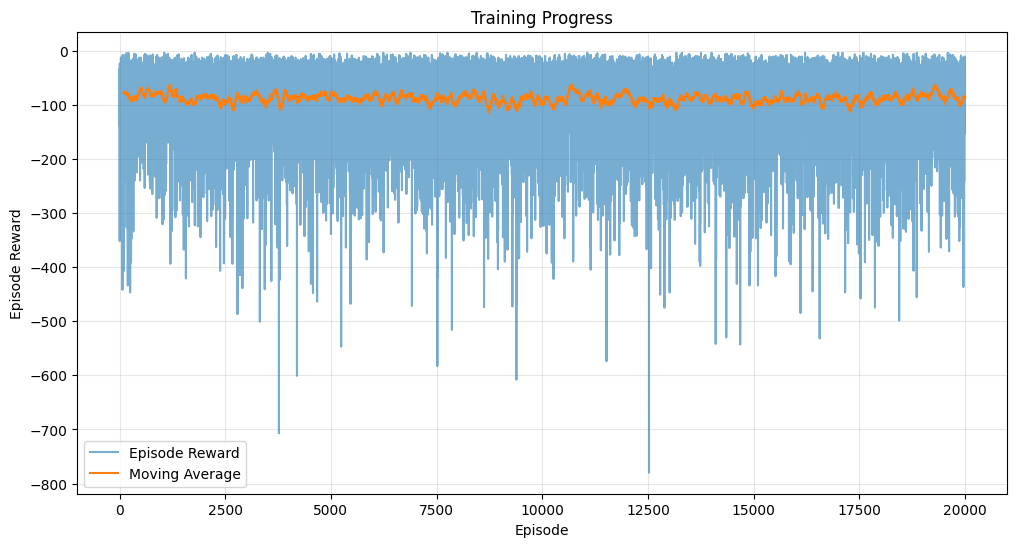


Evaluating trained agent...


In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
np.bool8 = np.bool_
# 策略网络
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_size),
            nn.Softmax(dim=-1)
        )
        
        # 使用正确的初始化方法
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0.0)
    
    def forward(self, x):
        return self.network(x)

class PolicyGradientAgent:
    def __init__(self, state_size, action_size):
        self.policy = PolicyNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.005)
        self.gamma = 0.99
        
    def select_action(self, state):
        state = torch.FloatTensor(state)
        # 添加探索机制
        if np.random.random() < 0.5:
            action = np.random.randint(0, 4)
            probs = self.policy(state)
            return action, torch.log(probs[action]+1e-8)
            
        
        probs = self.policy(state)
        distribution = Categorical(probs)
        action = distribution.sample()
        
        # 保存log概率用于后续训练
        return action.item(), distribution.log_prob(action)
    
    def update(self, rewards, log_probs):
        # 计算折扣回报
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        
        # 标准化回报以减少方差
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # 计算策略损失
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        policy_loss = torch.stack(policy_loss).sum()
        
        # 优化策略网络
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        return policy_loss

def train(env, agent, num_episodes):
    episode_rewards = []
    max_steps_per_episode = 1000  # 增加步数限制
    best_reward = float('-inf')
    
    for episode in range(num_episodes):
        state_tuple = env.reset()
        state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
        
        rewards = []
        log_probs = []
        episode_reward = 0
        done = False
        steps = 0
        
        while not done and steps < max_steps_per_episode:
            steps += 1
            state_onehot = np.zeros(48)
            state_onehot[state] = 1
            
            action, log_prob = agent.select_action(state_onehot)
            
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            # 修改奖励结构
            if reward == -100:  # 掉入悬崖
                reward = -10  # 减小惩罚力度，避免过度规避风险
            elif done and next_state == 47:  # 到达目标状态（右下角）
                reward = 10  # 给予明显的正向奖励
            
            rewards.append(reward)
            log_probs.append(log_prob)
            episode_reward += reward
            
            state = next_state
        
        avg_loss = agent.update(rewards, log_probs)
        episode_rewards.append(episode_reward)
        
        # 更新最佳奖励
        if episode_reward > best_reward:
            best_reward = episode_reward
        
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            success_rate = len([r for r in episode_rewards[-100:] if r > -100]) / 100
            print(f"Episode {episode + 1}")
            print(f"Steps: {steps}")
            print(f"Average Reward: {avg_reward:.2f}")
            print(f"Success Rate: {success_rate:.2%}")
            print(f"Best Reward: {best_reward:.2f}")
            print(f'length: {len(log_probs)}')
            print(f'loss: {avg_loss}')
            print("-" * 50)
    
    return episode_rewards

def plot_results(rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, alpha=0.6, label='Episode Reward')
    
    # 添加移动平均线
    window_size = 100
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(rewards)), moving_avg, label='Moving Average')
    
    plt.title('Training Progress')
    plt.xlabel('Episode')
    plt.ylabel('Episode Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def evaluate_agent(env, agent, num_episodes=10):
    """评估智能体的性能"""
    total_rewards = []
    total_steps = []
    success_count = 0
    
    for i in range(num_episodes):
        state_tuple = env.reset()
        state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
        episode_reward = 0
        steps = 0
        done = False
        
        while not done:
            state_onehot = np.zeros(48)
            state_onehot[state] = 1
            
            # 评估时使用最可能的动作
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state_onehot)
                probs = agent.policy(state_tensor)
                action = probs.argmax().item()
            
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            episode_reward += reward
            steps += 1
            state = next_state
            
            if done and reward != -100:  # 成功到达目标
                success_count += 1
        
        total_rewards.append(episode_reward)
        total_steps.append(steps)
        print(f"Evaluation Episode {i+1}: Reward = {episode_reward}, Steps = {steps}")
    
    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(total_steps)
    success_rate = success_count / num_episodes
    
    print("\nEvaluation Results:")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Average Steps: {avg_steps:.2f}")
    print(f"Success Rate: {success_rate:.2%}")
    return avg_reward

if __name__ == "__main__":
    # 创建环境
    env = gym.make('CliffWalking-v0')
    
    # 初始化智能体
    state_size = 48  # CliffWalking-v0的状态空间大小
    action_size = 4  # 上下左右四个动作
#     agent = PolicyGradientAgent(state_size, action_size)
    
    # 训练
    num_episodes = 20000
    rewards = train(env, agent, num_episodes)
    
    # 绘制训练结果
    plot_results(rewards)
    
    # 评估智能体
    print("\nEvaluating trained agent...")
    evaluate_agent(env, agent, num_episodes=10)
    
    # 关闭环境
    env.close()

In [52]:
def new_select_action(self, state):
    state = torch.FloatTensor(state)
    # 添加探索机制
    if np.random.random() < 0.2:
        action = np.random.randint(0, 4)
        probs = self.policy(state)
        return action, torch.log(probs[action]+1e-8)
        
    probs = self.policy(state)
    distribution = Categorical(probs)
    action = distribution.sample()
    
    # 保存log概率用于后续训练
    return action.item(), distribution.log_prob(action)

# 替换方法
import types
agent.select_action = types.MethodType(new_select_action, agent)

In [14]:
import pickle

In [17]:
torch.save(agent.policy.state_dict(),'policy.pt')

In [49]:
import time
def visualize_agent(env, agent, num_episodes=5):
    """
    渲染显示智能体的行动
    """
    env = gym.make('CliffWalking-v0', render_mode='human')  # 创建可视化环境
    
    for episode in range(num_episodes):
        state_tuple = env.reset()
        state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
        total_reward = 0
        steps = 0
        done = False
        
        print(f"\nEpisode {episode + 1}")
        
        while not done:
            env.render()  # 渲染当前状态
            
            # 将状态转换为one-hot编码
            state_onehot = np.zeros(48)
            state_onehot[state] = 1
            
            # 使用训练好的策略选择动作
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state_onehot)
                probs = agent.policy(state_tensor)
                action = probs.argmax().item()  # 使用最可能的动作
            
            # 执行动作
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            total_reward += reward
            steps += 1
            state = next_state
            
            # 添加小延迟使动作更容易观察
            time.sleep(0.5)
        
        print(f"Episode finished after {steps} steps. Total reward: {total_reward}")
    
    env.close()

# 在主程序最后添加：
if __name__ == "__main__":    
    # 训练完成后显示智能体行动
    print("\nVisualizing trained agent behavior...")
    visualize_agent(env, agent)


Visualizing trained agent behavior...

Episode 1
Episode finished after 15 steps. Total reward: -15

Episode 2
Episode finished after 15 steps. Total reward: -15

Episode 3
Episode finished after 15 steps. Total reward: -15

Episode 4
Episode finished after 15 steps. Total reward: -15

Episode 5
Episode finished after 15 steps. Total reward: -15


In [50]:
env.close()